# Relatório de Mercadoria do Mercado Livre - Argentina

**Diagrama de Alto Nível da Solução**

```
[Coletar Dados do Mercado Livre] --> [Armazenar Dados em Arquivo CSV] --> [Analisar Dados] --> [Visualizar Resultados em Dashboards]

```

**Documentação das Etapas:**

1. **Coletar Dados do Mercado Livre:**
   - Utilizar a API do Mercado Livre para buscar informações sobre produtos.
   - Definir os termos de pesquisa, limites de resultados e outras configurações necessárias.
   - Fazer solicitações à API para obter informações sobre os produtos.
   - Receber e armazenar as respostas da API.

2. **Armazenar Dados em Arquivo CSV:**
   - Criar um arquivo CSV para armazenar os dados coletados.
   - Estruturar os dados em colunas relevantes, como ID do produto, título, preço, condição, vendedor, etc.
   - Escrever os dados coletados no arquivo CSV.

3. **Analisar Dados:**
   - Carregar o arquivo CSV com os dados coletados.
   - Utilizar bibliotecas como pandas para realizar análises estatísticas e extrair insights.
   - Identificar padrões nos dados, como variação de preços ao longo do tempo, distribuição de memória RAM, etc.
   - Calcular métricas relevantes, como o vendedor com mais produtos, condição mais comum dos produtos, etc.

4. **Visualizar Resultados em Dashboards:**
   - Utilizar bibliotecas como Dash e Plotly para criar dashboards interativos.
   - Criar visualizações de dados, como gráficos de linha, histogramas, box plots, etc.
   - Integrar os dados analisados nos dashboards.
   - Permitir a interação do usuário com os dashboards, como alternar entre diferentes visualizações com base em abas ou filtros.


## Extraindo Dados

### Instalação de dependências

In [ ]:
pip install dash pandas plotly

### Extração dos dados na API

In [79]:
import requests
import pandas as pd
import csv
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

def buscar_ids_e_detalhes_itens(termos_de_pesquisa, limite_por_pagina=50, total_de_resultados_por_termo=150):
    """
    Busca IDs e detalhes de itens no Mercado Livre com base em termos de pesquisa fornecidos.

    Args:
        termos_de_pesquisa (list of str): Lista de termos de pesquisa para buscar itens.
        limite_por_pagina (int): Número de resultados por página (default: 50).
        total_de_resultados_por_termo (int): Número total de resultados a serem obtidos para cada termo de pesquisa (default: 150).

    Returns:
        tuple: Um DataFrame contendo os IDs dos itens e um dicionário com as respostas JSON dos itens.

    Example:
        termos_de_pesquisa = ["iPhone", "Galaxy", "Redmi"]
        df_ids_dos_itens, respostas_json = buscar_ids_e_detalhes_itens(termos_de_pesquisa)
    """
    # DataFrame para armazenar os IDs dos itens
    df_ids_dos_itens = pd.DataFrame(columns=["Termo", "ID"])

    # Lista para armazenar dicionários de IDs de itens
    lista_de_ids_dos_itens = []

    # Dicionário para armazenar as respostas JSON
    respostas_json = {}

    # Loop sobre os termos de pesquisa
    for termo in termos_de_pesquisa:
        # Calcula o número total de páginas necessárias com base no limite por página
        total_de_paginas_por_termo = -(-total_de_resultados_por_termo // limite_por_pagina)

        # Loop sobre cada página de resultados para o termo atual
        for pagina in range(total_de_paginas_por_termo):
            # Calcula o índice inicial para esta página
            indice_inicial = pagina * limite_por_pagina

            # Faz uma solicitação à API do Mercado Livre para os itens neste termo e página
            response = requests.get(f"https://api.mercadolibre.com/sites/MLA/search?q={termo}&limit={limite_por_pagina}&offset={indice_inicial}")

            # Verifica se a solicitação foi bem-sucedida
            if response.status_code == 200:
                # Extrai os IDs dos itens da resposta JSON e adiciona à lista
                resultados = response.json()["results"]
                for item in resultados:
                    item_id = item["id"]
                    lista_de_ids_dos_itens.append({"Termo": termo, "ID": item_id})
                    # Realiza uma solicitação GET para obter mais informações sobre o item e armazena a resposta JSON no dicionário
                    item_response = requests.get(f"https://api.mercadolibre.com/items/{item_id}")
                    if item_response.status_code == 200:
                        respostas_json[item_id] = item_response.json()
                    else:
                        print(f"A solicitação para o item {item_id} falhou com o código de status {item_response.status_code}")
            else:
                print(f"A solicitação para a página {pagina + 1} do termo '{termo}' falhou com o código de status {response.status_code}")

    # Converte a lista de dicionários em um DataFrame
    df_ids_dos_itens = pd.DataFrame(lista_de_ids_dos_itens)

    return df_ids_dos_itens, respostas_json

# Exemplo de uso da função
termos_de_pesquisa = ["iPhone", "Galaxy", "Redmi"]
df_ids_dos_itens, respostas_json = buscar_ids_e_detalhes_itens(termos_de_pesquisa)


### Preenchendo dados em um CSV

In [84]:
def escrever_resultados_no_csv(respostas_json, df_ids_dos_itens, nome_arquivo='resultados2.csv'):
    """
    Escreve os resultados obtidos em um arquivo CSV.

    Args:
        respostas_json (dict): Dicionário contendo as respostas JSON dos itens.
        df_ids_dos_itens (pd.DataFrame): DataFrame contendo os IDs dos itens e os termos de pesquisa correspondentes.
        nome_arquivo (str): Nome do arquivo CSV onde os resultados serão salvos (default: 'resultados2.csv').

    Returns:
        None

    Example:
        escrever_resultados_no_csv(respostas_json, df_ids_dos_itens)
    """
    # Abre um arquivo CSV em modo de escrita
    with open(nome_arquivo, 'w', newline='', encoding='utf-8') as csvfile:
        # Define os campos do cabeçalho do CSV
        fieldnames = ['Vendedor_id','Termo', 'ID', 'Titulo', 'Preco', 'Condicao', 'Moeda', 'Tempo de Garantia', 'Cameras Traseiras', 'Memória RAM', 'Data']

        # Cria um escritor CSV
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Escreve o cabeçalho do CSV
        writer.writeheader()

        # Itera sobre as respostas JSON
        for item_id, item_info in respostas_json.items():
            # Extrai as informações relevantes do item
            termo = df_ids_dos_itens.loc[df_ids_dos_itens['ID'] == item_id, 'Termo'].iloc[0]
            titulo = item_info.get('title', '')
            preco = item_info.get('price', 0)
            condicao = item_info.get('condition', '')
            #vendidos = item_info.get('sold_quantity', 0) -> não existe nessa api passada
            #disponiveis = item_info.get('available_quantity', 0) -> não existe nessa api passada
            moeda = item_info.get('currency_id', '')
            tempo_de_garantia = item_info.get('warranty', '')
            vendedor = item_info.get('seller_id','')
            data = item_info.get('date_created', '')

            # Extrai a memória RAM
            memoria_ram = ''
            memory_info = item_info.get('attributes', {})
            for attr in memory_info:
                if attr.get('id', '') == 'RAM':
                    memoria_ram = attr.get('value_name', '')
                    break

            # Extrai as câmeras traseiras
            cameras_traseiras = ''
            cameras_info = item_info.get('attributes', {})
            for attr in cameras_info:
                if attr.get('id', '') == 'REAR_CAMERAS_RESOLUTION':
                    cameras_traseiras = attr.get('value_name', '')
                    break

            # Escreve uma linha no CSV com as informações do item
            writer.writerow({'Vendedor_id': vendedor, 'Termo': termo, 'ID': item_id, 'Titulo': titulo, 'Preco': preco, 'Condicao': condicao, 'Moeda': moeda, 'Tempo de Garantia': tempo_de_garantia, 'Cameras Traseiras': cameras_traseiras, 'Memória RAM': memoria_ram, 'Data': data})

# Exemplo de uso da função
escrever_resultados_no_csv(respostas_json, df_ids_dos_itens)


In [85]:
df = pd.read_csv('resultados2.csv')
df.head()

,Vendedor_id,Termo,ID,Titulo,Preco,Condicao,Moeda,Tempo de Garantia,Cameras Traseiras,Memória RAM,Data
0,195832229,iPhone,MLA1275795996,"Apple iPhone SE Se (3ª Generación, 128 Gb) - B...",1801998.0,new,ARS,Garantía de fábrica: 12 meses,NaN,4 GB,2022-12-07T15:03:23.000Z
1,196230127,iPhone,MLA1437424818,Apple iPhone 11 (128 Gb) - Negro,808733.0,new,ARS,Garantía de fábrica: 12 meses,12 Mpx/12 Mpx,4 GB,2023-06-23T17:36:36.000Z
2,196230127,iPhone,MLA1441494498,Apple iPhone 13 (128 Gb) - Azul Medianoche,1134761.0,new,ARS,Garantía de fábrica: 12 meses,12 Mpx/12 Mpx,4 GB,2023-07-01T23:59:09.000Z
3,75279749,iPhone,MLA1476397232,iPhone 6 iPhone 6s 32 Gb Gris Espacial,419999.0,new,ARS,Garantía de fábrica: 3 meses,12 Mpx,2 GB,2023-08-18T15:04:05.000Z
4,419467681,iPhone,MLA1391035763,Apple iPhone 15 Pro Max (256 Gb) - Titanio Azul,2125499.0,new,ARS,Garantía de fábrica: 12 meses,48 Mpx/12 Mpx/12 Mpx,8 GB,2023-10-02T22:34:32.000Z


## Geração de insights

### Relatório de Variação de Preço

In [ ]:
# Calcula a variação percentual de preço para cada produto
def calcular_variacao_preco(df, produto):
    df_produto = df[df['Titulo'].str.contains(produto, case=False)]
    preco_inicial = df_produto['Preco'].iloc[0]
    preco_final = df_produto['Preco'].iloc[-1]
    variacao_percentual = ((preco_final - preco_inicial) / preco_inicial) * 100
    return variacao_percentual

# Produtos de interesse
produtos = ['iPhone', 'Samsung', 'Redmi']

# Cria o relatório
relatorio = {}
for produto in produtos:
    variacao = calcular_variacao_preco(df, produto)
    relatorio[produto] = variacao

# Imprime o relatório
for produto, variacao in relatorio.items():
    print(f"No {produto} teve uma variação de {variacao:.2f}% durante esse tempo.")


No iPhone teve uma variação de -47.28% durante esse tempo.
No Samsung teve uma variação de -27.14% durante esse tempo.
No Redmi teve uma variação de 8.80% durante esse tempo.


In [106]:
# Produtos e suas variações percentuais
produtos = list(relatorio.keys())
variacao_percentual = list(relatorio.values())

# Criação do gráfico de barras
fig = go.Figure(data=[go.Bar(x=produtos, y=variacao_percentual)])

# Adiciona título e rótulos aos eixos
fig.update_layout(title='Variação Percentual de Preço por Produto',
                   xaxis_title='Produto',
                   yaxis_title='Variação Percentual de Preço (%)')

# Exibe o gráfico
fig.show()


### Produto mais anunciado, novo ou usado

In [ ]:
# Calcula a contagem de ocorrências de cada valor único na coluna 'condicao'
contagem_condicoes = df['Condicao'].value_counts()

# Encontra o resultado mais usado
condicao_mais_usada = contagem_condicoes.idxmax()
contagem_mais_usada = contagem_condicoes.max()

# Encontra o resultado menos usado
condicao_menos_usada = contagem_condicoes.idxmin()
contagem_menos_usada = contagem_condicoes.min()

# Imprime os resultados
print(f"A condição mais comum é '{condicao_mais_usada}' com {contagem_mais_usada} ocorrências.")
print(f"A condição menos comum é '{condicao_menos_usada}' com {contagem_menos_usada} ocorrências.")


A condição mais comum é 'new' com 435 ocorrências.
A condição menos comum é 'used' com 11 ocorrências.


### Vendedor com mais produtos

In [ ]:
# Calcula a contagem de produtos para cada vendedor
contagem_por_vendedor = df['Vendedor_id'].value_counts()

# Encontra o vendedor com mais produtos
vendedor_mais_produtos = contagem_por_vendedor.idxmax()
quantidade_produtos = contagem_por_vendedor.max()

# Imprime o resultado
print(f"O vendedor com mais produtos é '{vendedor_mais_produtos}' com {quantidade_produtos} produtos.")


O vendedor com mais produtos é '1158735105' com 30 produtos.


### Visualização do Dados

In [101]:
df['Data'] = pd.to_datetime(df['Data'])

# Inicializa o aplicativo Dash
app = dash.Dash(__name__) #app = dash.Dash(__name__): Esta linha cria uma instância do aplicativo Dash. O __name__ é uma variável especial do Python que contém o nome do módulo atual
app.title = "Mercado Livre Dashboard"

app.layout = html.Div([
    dcc.Tabs(id="tabs", value='tab-1', children=[
        dcc.Tab(label='Faixa de Preços por Termo', value='tab-1'),
        dcc.Tab(label='Variação de Preços ao Longo do Tempo', value='tab-2'),
        dcc.Tab(label='Distribuição de Memória RAM', value='tab-3'),
        dcc.Tab(label='Distribuição de Resolução de Câmeras Traseiras', value='tab-4'),
    ]),
    html.Div(id='tabs-content')
])

# Callback para atualizar o conteúdo das abas
#Este é um decorador usado para definir uma função de retorno de chamada que atualiza o conteúdo do aplicativo com base na interação do usuário.
@app.callback(Output('tabs-content', 'children'), #Esta função de retorno de chamada atualiza o conteúdo
              Input('tabs', 'value'))# função de retorno de chamada é acionada quando o valor da aba (tabs) muda.

def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
            dcc.Graph(
                id='precos-por-termo',
                figure=px.box(df, x='Termo', y='Preco', title='Faixa de Preços por Termo de Pesquisa'), style={'width': '100%', 'height': '900px'}
            )
        ])
    elif tab == 'tab-2':
        df_precos = df[df['Titulo'].str.contains('iPhone 12', case=False)]
        return html.Div([
            dcc.Graph(
                id='variacao-precos-tempo',
                figure=px.line(df_precos, x='Data', y='Preco', color='Titulo', title='Variação de Preços ao Longo do Tempo', markers=True), style={'width': '100%', 'height': '900px'}
            )
        ])
    elif tab == 'tab-3':
        return html.Div([
            dcc.Graph(
                id='distribuicao-memoria-ram',
                figure=px.histogram(df, x='Memória RAM', title='Distribuição de Memória RAM'), style={'width': '100%', 'height': '900px'}
            )
        ])
    elif tab == 'tab-4':
        return html.Div([
            dcc.Graph(
                id='distribuicao-cameras-traseiras',
                figure=px.histogram(df, x='Cameras Traseiras', title='Distribuição de Resolução de Câmeras Traseiras'), style={'width': '100%', 'height': '900px'}
            )
        ])

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

### Comparação de Preços Entre Vendedores

In [90]:
# Função para comparar preços de um produto específico
def comparar_precos(termo, produto):
    df_produto = df[(df['Termo'] == termo) & (df['Titulo'].str.contains(produto, case=False))]
    df_produto = df_produto[['Titulo', 'Preco', 'Vendedor_id']].sort_values(by='Preco')
    return df_produto

# Exemplo de uso
comparar_precos('iPhone', 'iPhone 12')


,Titulo,Preco,Vendedor_id
139,iPhone 12 Pro Max 128 Gb Azul Pacífico,560000.0,386332943
75,iPhone 12 128 Gb Medianoche,723128.0,166454782
98,Apple iPhone 12 64gb Rojo Cargador Cable Glass...,787500.0,147865261
89,Apple iPhone 12 Mini (128 Gb) - (product)red,827764.0,166454782
137,Apple iPhone 12 128gb Blanco Cargador Cable Gl...,842495.0,147865261
119,Apple iPhone 12 128gb Rojo Cargador Cable Glas...,853800.0,147865261
37,Apple iPhone 12 Pro (128 Gb) - Plata,950000.0,229801509
50,iPhone 12 Pro Max Gold 256 Gb,964308.8,166454782
114,iPhone 12 Pro 256gb Graphite Cargador Cable Fu...,1085850.0,147865261
74,iPhone 12 Pro Max 256 Gb Azul,1104376.0,166454782


### Relatórios Periódicos

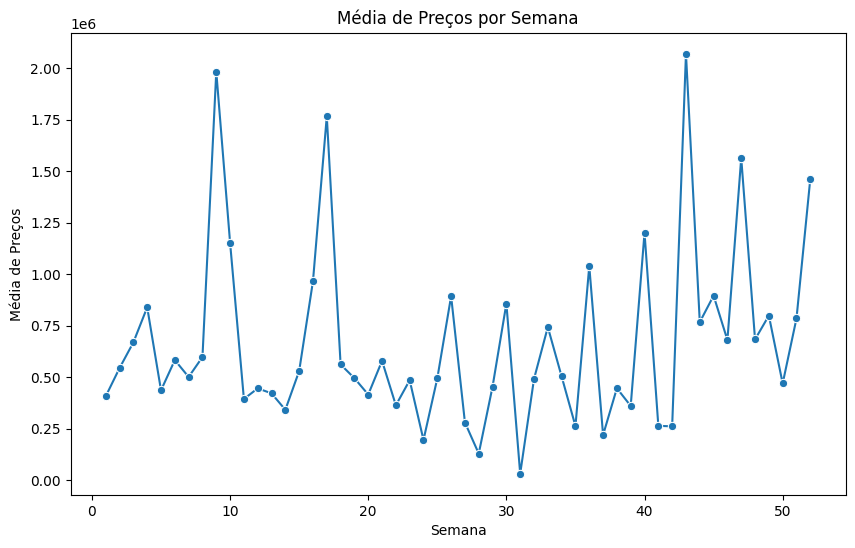

In [105]:
# Função para gerar relatório de preços semanal
def gerar_relatorio_semanal(df):
    df['Data'] = pd.to_datetime(df['Data'])
    df['Semana'] = df['Data'].dt.isocalendar().week
    precos_semanal = df.groupby('Semana')['Preco'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Semana', y='Preco', data=precos_semanal, marker='o')
    plt.title('Média de Preços por Semana')
    plt.xlabel('Semana')
    plt.ylabel('Média de Preços')
    plt.show()

# Gera o relatório
gerar_relatorio_semanal(df)
